In [29]:
import math
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

torch.manual_seed(42)
np.random.seed(42)

## Data
- [MovieLens 10M Dataset](https://grouplens.org/datasets/movielens/) 
- 원본 파일에는 header 없으므로 (userId::movieId::rating::timestamp)를 파일 상단에 추가하거나 불러온 후에 수정해야 함


In [ ]:
raw_data = pd.read_csv("ratings.dat", sep="::")

item2idx, idx2item = {}, {}
user2idx, idx2user = {}, {}
id2title = {}

for idx, user_id in enumerate(np.unique(raw_data["userId"])):
    user2idx[user_id] = idx
    idx2user[idx] = user_id
for idx, item_id in enumerate(np.unique(raw_data["movieId"])):
    item2idx[item_id] = idx
    idx2item[idx] = item_id

# make index data
index_data = raw_data[["movieId",'userId','timestamp']].copy()
index_data["userId"] = raw_data["userId"].apply(lambda idx:user2idx[idx])
index_data["movieId"] = raw_data["movieId"].apply(lambda idx:item2idx[idx])
index_data.sort_values(['userId', 'timestamp'], inplace=True)

n_user = np.unique(raw_data["userId"]).shape[0]
n_item = np.unique(raw_data["movieId"]).shape[0]

users = defaultdict(list)
train = {}
valid = {}

for u, i, t in zip(index_data['userId'], index_data['movieId'], index_data['timestamp']):
    users[u].append(i)

# train/valid split
for u in users:
    train[u] = users[u][:-1]
    valid[u] = [users[u][-1]]

In [3]:
raw_data

,userId,movieId,rating,timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392
...,...,...,...,...
10000049,71567,2107,1.0,912580553
10000050,71567,2126,2.0,912649143
10000051,71567,2294,5.0,912577968
10000052,71567,2338,2.0,912578016


In [4]:
print(n_user, n_item)

69878 10677


In [5]:
index_data.head(20)

,movieId,userId,timestamp
18,582,0,838983339
2,228,0,838983392
4,313,0,838983392
5,325,0,838983392
3,289,0,838983421
1,183,0,838983525
7,352,0,838983653
14,476,0,838983653
9,360,0,838983707
19,583,0,838983778


In [6]:
def neg_sampling(low, high, seq):
    neg = np.random.randint(low, high)
    while neg in seq:
        neg = np.random.randint(low, high)
    return neg

def sample_batch(train, n_user, n_item, batch_size, max_len):
    def sample():
        user = np.random.randint(n_user)

        seq = np.zeros([max_len], dtype=np.int32)
        pos = np.zeros([max_len], dtype=np.int32)
        neg = np.zeros([max_len], dtype=np.int32)
        next_item = train[user][-1]
        idx = max_len-1

        train_item = set(train[user])

        for i in reversed(train[user][:-1]):
            seq[idx] = i
            pos[idx] = next_item

            if next_item:
                neg[idx] = neg_sampling(1, n_item+1, train_item) # user가 소비하지 않은 아이템 neg_sampling
            
            next_item = i
            idx -= 1
            
            if idx<0:
                break
        
        return (user, seq, pos, neg)
    
    user, seq, pos, neg = zip(*[sample() for _ in range(batch_size)])
    user, seq, pos, neg = np.array(user), np.array(seq), np.array(pos), np.array(neg)
    return user, seq, pos, neg

## Model 

#### self-attention layer

In [7]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, head_units, dropout_rate) -> None:
        super(ScaledDotProductAttention, self).__init__()
        self.head_units = head_units
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, Q, K, V, mask):
        attn_score = torch.matmul(Q, K.transpose(2, 3)) / math.sqrt(self.head_units)
        attn_score = attn_score.masked_fill(mask == 0, -1e9)  # masking
        attn_dist = self.dropout(F.softmax(attn_score, dim=-1)) 
        output = torch.matmul(attn_dist, V)  # batch x num_head x seqLen x head_units
        return output, attn_dist
    

class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, hidden_units, dropout_rate):
        super(MultiHeadAttention, self).__init__()
        self.n_heads = n_heads
        self.hidden_units = hidden_units
        self.head_units = self.hidden_units//self.n_heads

        # query, key, value, output
        self.W_Q = nn.Linear(self.hidden_units, self.hidden_units, bias=False)
        self.W_K = nn.Linear(self.hidden_units, self.hidden_units, bias=False)
        self.W_V = nn.Linear(self.hidden_units, self.hidden_units, bias=False)
        self.W_O = nn.Linear(self.hidden_units, self.hidden_units, bias=False)

        self.attention = ScaledDotProductAttention(self.head_units, dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)
        self.layerNorm = nn.LayerNorm(self.hidden_units, 1e-6)

    def forward(self, enc, mask):
        residual = enc 
        batch_size, seqlen = enc.size(0), enc.size(1)

        # head 개수로 분리
        Q = self.W_Q(enc).view(batch_size, seqlen, self.n_heads, -1)
        K = self.W_K(enc).view(batch_size, seqlen, self.n_heads, -1)
        V = self.W_V(enc).view(batch_size, seqlen, self.n_heads, -1)

        # attention 
        Q, K, V = Q.transpose(1, 2), K.transpose(1, 2), V.transpose(1, 2)
        output, attn_dist = self.attention(Q, K, V, mask)

        # head concat
        output = output.transpose(1, 2).contiguous()
        output = output.view(batch_size, seqlen, -1)

        # Dropout, Residual connection, Layer Normalization
        output = self.layerNorm(self.dropout(self.W_O(output)) + residual)
        return output, attn_dist

#### FFN

In [8]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, hidden_units, dropout_rate):
        super(PositionwiseFeedForward, self).__init__()

        self.W_1 = nn.Linear(hidden_units, hidden_units)
        self.W_2 = nn.Linear(hidden_units, hidden_units)
        self.dropout = nn.Dropout(dropout_rate)
        self.layerNorm = nn.LayerNorm(hidden_units, 1e-6)

    def forward(self, x):
        residual = x
        output = self.W_2(F.relu(self.dropout(self.W_1(x))))
        output = self.layerNorm(self.dropout(output) + residual)
        return output

#### self-attention block

In [9]:
class SASRecBlock(nn.Module):
    def __init__(self, n_heads, hidden_units, dropout_rate):
        super(SASRecBlock, self).__init__()
        self.attention = MultiHeadAttention(n_heads, hidden_units, dropout_rate)
        self.pointwise_feedforward = PositionwiseFeedForward(hidden_units, dropout_rate)

    def forward(self, input_enc, mask):
        output_enc, attn_dist = self.attention(input_enc, mask)
        output_enc = self.pointwise_feedforward(output_enc)
        return output_enc, attn_dist

#### SASRec


In [10]:
class SASRec(nn.Module):
    def __init__(self, n_user, n_item, hidden_units, n_heads, n_layers, maxlen, dropout_rate, device):
        super(SASRec, self).__init__()

        self.n_user = n_user
        self.n_item = n_item
        self.hidden_units = hidden_units
        self.n_heads = n_heads
        self.n_layers = n_layers
        self.device = device

        self.item_emb = nn.Embedding(n_item + 1, hidden_units, padding_idx=0)
        self.pos_emb = nn.Embedding(maxlen, hidden_units) # learnable positional encoding
        self.dropout = nn.Dropout(dropout_rate)
        self.emb_layernorm = nn.LayerNorm(hidden_units, eps=1e-6)

        self.blocks = nn.ModuleList([SASRecBlock(n_heads, hidden_units, dropout_rate) for _ in range(n_layers)])

    def feats(self, log_seqs):
        seqs = self.item_emb(torch.LongTensor(log_seqs).to(self.device))
        positions = np.tile(np.array(range(log_seqs.shape[1])), [log_seqs.shape[0], 1])
        seqs += self.pos_emb(torch.LongTensor(positions).to(self.device))
        seqs = self.emb_layernorm(self.dropout(seqs))

        # masking
        mask_pad = torch.BoolTensor(log_seqs > 0).unsqueeze(1).unsqueeze(1)
        mask_time = (1 - torch.triu(torch.ones((1, 1, seqs.size(1), seqs.size(1))), diagonal=1)).bool()
        mask = (mask_pad & mask_time).to(self.device)
        for block in self.blocks:
            seqs, attn_dist = block(seqs, mask)
        return seqs

    def forward(self, log_seqs, pos_seqs, neg_seqs):
        feats = self.feats(log_seqs)
        pos_embs = self.item_emb(torch.LongTensor(pos_seqs).to(self.device))
        neg_embs = self.item_emb(torch.LongTensor(neg_seqs).to(self.device))

        pos_logits = (feats * pos_embs).sum(dim=-1)
        neg_logits = (feats * neg_embs).sum(dim=-1)
        return pos_logits, neg_logits

    def predict(self, log_seqs, item_indices):
        final_feats = self.feats(log_seqs)[:, -1, :] # F_t
        item_embs = self.item_emb(torch.LongTensor(item_indices).to(self.device))
        logits = item_embs.matmul(final_feats.unsqueeze(-1)).squeeze(-1)
        return logits

## Train

In [14]:
# model setting
max_len = 60
hidden_units = 128
n_heads = 4
n_layers = 2
dropout_rate=0.4
device = 'cpu' # 'cuda' for GPU

# training setting
lr = 0.001
batch_size = 128
num_epochs = 10
num_batch = n_user // batch_size

In [15]:
# setting
model = SASRec(n_user, n_item, hidden_units, n_heads, n_layers, max_len, dropout_rate, device)
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=lr)

In [16]:
train_loss = []

# training
for epoch in range(1, num_epochs + 1):
    tbar = tqdm(range(num_batch))
    batch_loss = 0
    for step in tbar: # num_batch만큼 sampling
        user, seq, pos, neg = sample_batch(train, n_user, n_item, batch_size, max_len)
        pos_logits, neg_logits = model(seq, pos, neg)
        pos_labels, neg_labels = torch.ones(pos_logits.shape, device=device), torch.zeros(neg_logits.shape, device=device)

        optimizer.zero_grad()
        indices = np.where(pos != 0) # padding 제외
        loss = criterion(pos_logits[indices], pos_labels[indices])
        loss += criterion(neg_logits[indices], neg_labels[indices])
        loss.backward()
        optimizer.step()

        batch_loss += loss.item()

        tbar.set_description(f'Epoch: {epoch:3d}| Step: {step:3d}| Train loss: {loss:.5f}')

    train_loss.append(batch_loss/num_batch)

Epoch:   1| Step: 544| Train loss: 1.06341: 100%|██████████| 545/545 [01:43<00:00,  5.26it/s]
Epoch:   2| Step: 544| Train loss: 0.71028: 100%|██████████| 545/545 [01:44<00:00,  5.20it/s]
Epoch:   3| Step: 544| Train loss: 0.71531: 100%|██████████| 545/545 [01:44<00:00,  5.20it/s]
Epoch:   4| Step: 544| Train loss: 0.78637: 100%|██████████| 545/545 [01:37<00:00,  5.58it/s]
Epoch:   5| Step: 544| Train loss: 0.71682: 100%|██████████| 545/545 [01:42<00:00,  5.29it/s]
Epoch:   6| Step: 544| Train loss: 0.66508: 100%|██████████| 545/545 [01:37<00:00,  5.56it/s]
Epoch:   7| Step: 544| Train loss: 0.73467: 100%|██████████| 545/545 [01:46<00:00,  5.11it/s]
Epoch:   8| Step: 544| Train loss: 0.72947: 100%|██████████| 545/545 [01:40<00:00,  5.43it/s]
Epoch:   9| Step: 544| Train loss: 0.70529: 100%|██████████| 545/545 [01:38<00:00,  5.51it/s]
Epoch:  10| Step: 544| Train loss: 0.71457: 100%|██████████| 545/545 [01:39<00:00,  5.46it/s]


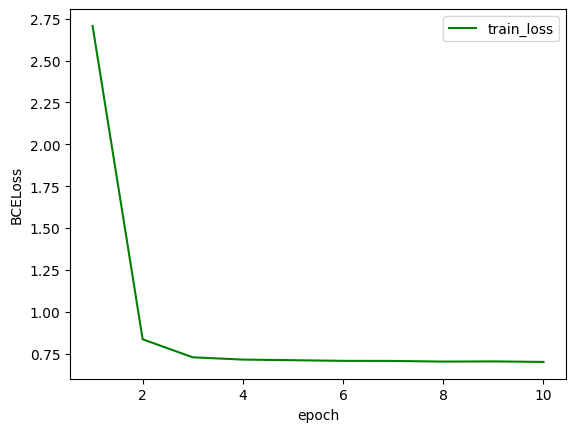

In [19]:
plt.xlabel("epoch")
plt.ylabel("BCELoss")
plt.plot(range(1,num_epochs+1), train_loss, color = "green", label='train_loss')
plt.legend()

## Eval

In [33]:
model.eval()

NDCG = 0.0 # NDCG@10
HIT = 0.0 # HIT@10

num_item_sample = 100
num_user_sample = 1000
users = np.random.randint(0, n_user, num_user_sample) # user sampling

for u in users:
    seq = train[u][-max_len:]
    rated = set(train[u] + valid[u])
    item_idx = valid[u] + [neg_sampling(1, n_item + 1, rated) for _ in range(num_item_sample)]

    with torch.no_grad():
        predictions = -model.predict(np.array([seq]), np.array(item_idx)) # 예측값의 부호 반대로
        predictions = predictions[0]
        rank = predictions.argsort().argsort()[0].item() + 1 # sorting and get ranking

    if rank < 10: 
        NDCG += 1 / np.log2(rank + 1)
        HIT += 1
print(f'NDCG@10: {NDCG/num_user_sample}| HIT@10: {HIT/num_user_sample}')

NDCG@10: 0.41801066657587355| HIT@10: 0.675
